In [1]:
import pandas as pd
import numpy as np
import folium
import requests
import json
import pprint
import datetime as dt
import re
import sympy
import matplotlib.pyplot as plt

In [2]:
room_data = pd.read_csv('room.csv',encoding='CP949')
room_data.head()

,건물명(상호명),건물위치,주택유형구분,세대수(객실수),건축연도
0,NaN,전라북도 전주시 덕진구 고랑동 819-5,다세대주택(3세대),3,19920810
1,NaN,전라북도 전주시 덕진구 금암동 1569-6,다세대주택(3세대),6,19891206
2,NaN,전라북도 전주시 덕진구 금암동 1588-23,다세대주택(3세대),3,19890803
3,휴엔하임 주상복합 아파트,전라북도 전주시 덕진구 금암동 1639-1,"공동주택(아파트), 업무시설(오피스텔), 근린생활시설",30,20161128
4,NaN,전라북도 전주시 덕진구 금암동 525-83,다세대주택,4,19891121


In [3]:
room_data['세대수(객실수)'].value_counts()

3      1332
10     1066
11      788
9       643
4       616
5       576
8       542
2       497
6       423
12      349
7       302
15      296
13      246
18      201
1       192
0       169
14      134
16      129
19      111
17       91
30        4
20        3
54        2
159       2
56        2
24        1
48        1
288       1
182       1
110       1
73        1
172       1
44        1
34        1
826       1
77        1
53        1
27        1
51        1
167       1
276       1
28        1
191       1
Name: 세대수(객실수), dtype: int64

In [4]:
room_data['주택유형구분'].value_counts()

단독주택                          3751
단독주택,제1종근린생활시설                 679
다가구주택                          494
단독주택(다가구주택)                    417
단독주택(3가구)                      196
                              ... 
단독주택(다가구), 제2종근린생활시설             1
(다가구주택) 및 제2종근린생활시설(일반음식점)       1
근린생활시설, 대피소, 주택(5가구), 화장실        1
단독주택 다가구                         1
제1종근린생활시설, 다가구, 대피소              1
Name: 주택유형구분, Length: 741, dtype: int64

In [5]:
room_data.describe()

,세대수(객실수)
count,8734.000000
mean,8.135791
std,11.724445
min,0.000000
25%,3.000000
50%,8.000000
75%,11.000000
max,826.000000


In [6]:
p = re.compile(r'\d+')
room_data['건축연도'] = room_data['건축연도'].map(lambda x: x if p.search(x) else '0')
room_data.drop(room_data[room_data['건축연도'].map(lambda x:int(x[:4])) < 1945].index, inplace=True) #해방 전 옛 건물들 제거
room_data.drop(room_data[room_data['세대수(객실수)']<1].index, inplace=True) #세대수가 0인 것 제거
room_data['const_year_point'] = 5-(dt.datetime.today().year-room_data['건축연도'].map(lambda x: int(x[:4])))//5

room_data.describe()

,세대수(객실수),const_year_point
count,8555.000000,8555.000000
mean,8.301344,2.547165
std,11.789038,1.858123
min,1.000000,-10.000000
25%,4.000000,1.000000
50%,8.000000,3.000000
75%,11.000000,4.000000
max,826.000000,5.000000


In [7]:
# TODO
# 건물 위치를 참조하여 folium에 좌표 찍기
# 건축 연도를 참조하여 room_data에 신축 / 준신축 / 보통 / 재건축필요 등의 등급으로 분류

# room_data['건물위치']
# key = "7F8A26C5-7C0A-318B-A521-FE1AA35942DB"
# arr = []
# f = open("./loc_all.txt", 'w')
# f.close()
# import time
# for i in room_data['건물위치']:
#     f = open("./loc_all.txt", 'a')
#     location = i.strip()
#     response = requests.get(f"http://api.vworld.kr/req/address?service=address&request=getCoord&key={key}&address={location}&type=PARCEL")
#     if 'result' in response.json()['response']:
#         x= float(response.json()['response']['result']['point']['x'])
#         y = float(response.json()['response']['result']['point']['y'])
#         arr.append([float(x),float(y)])
#         f.write(str(x))
#         f.write(',')
#         f.write(str(y))
#         f.write(',')
#         f.write(location)
#         f.write('\n')
#         f.close()
#     else:
#         print(location, response.json())
#     time.sleep(0.05)

In [21]:
f = open('./loc.txt', 'r')
lines = f.readlines()
map1 = folium.Map(location=[35.83001,127.125001], zoom_start=13)
arr = []
for line in lines:
    lat,long = map(float, line.split(','))
    lat = round(lat,2)
    long = round(long,2)
    if [lat,long] not in arr:
        arr.append([lat,long])

for content in arr:
    lat,long = content
    folium.Marker([long, lat], popup=f'{long}-{lat}의 원룸', icon=folium.Icon(color='red',icon='info-sign')).add_to(map1)
    folium.Circle([long, lat], radius=100, color='#3186cc', fill_color='#3186cc', popup=f'{long}-{lat}의 원룸 반경 100M').add_to(map1)
    folium.Circle([long, lat], radius=500, color='#ebe134', fill_color='#ebe134', popup=f'{long}-{lat}의 원룸 반경 500m').add_to(map1)
map1.save('map1.html')

In [9]:
from bs4 import BeautifulSoup

url = "http://openapi.jeonju.go.kr/jeonjubus/openApi/traffic/bus_location2_stopnm_common.do?serviceKey=cjE984BWrGFH3DFA2kLDoNx7j950nWjp6Ajz0CBaEABY5arYHY1C80RNBw6ptmayEV6B0zzpOfAbB73miZ4gnA%3D%3D&searchFld=searchNM&searchNm=%EC%95%88%EA%B3%A8"
response = requests.get(url)
data = BeautifulSoup(response.text, 'xml')
stopX = data('stopX')
stopY = data('stopY')
stopKname = data('stopKname')
stopId = data('stopStandardid')
bus_stop_arr = []

for i in range(len(stopX)):
    x=float(stopX[i].text)
    y=float(stopY[i].text)
    name = stopKname[i].text
    stop_id = int(str(stopId[i].text).strip())
    if 35.78<y and y<35.94 and 127.06<x and x<127.19:
        bus_stop_arr.append([x,y,name,stop_id])
bus_stop_arr.sort(key=lambda x:x[0])
print(len(bus_stop_arr))
for element in bus_stop_arr:
    if (35.78<element[1] and element[1]<35.94) and (127.06<element[0] and element[0]<127.19):
        folium.Marker([element[1], element[0]], popup=f'위도 : {element[1]}-경도 : {element[0]}:{element[2]}', icon=folium.Icon(color='green',icon='info-sign')).add_to(map1)
        
map1.save('map_bus.html')

1408


In [10]:
### 반지름 내의 원에 정류장 좌표가 몇 개 있는지 계산

for content in arr[-2:-1]:
    print(content)
    station_count = 0
    bus_count = 0
    content_lat = content[0]
    content_long = content[1]
    near_bus_stop = []
    bus_route_arr = []
    for bus_stop in bus_stop_arr:
        if bus_stop[0]>content_lat-0.005 and bus_stop[0]<content_lat+0.005 and bus_stop[1]>content_long-0.005 and bus_stop[1]<content_long+0.005:
            near_bus_stop.append(bus_stop)
    for bus_stop in near_bus_stop:
        if ((content_lat-bus_stop[0])**2+(content_long-bus_stop[1])**2)**(1/2) <= ((content_lat-(content_lat-0.0055))**2+(content_long-(content_long-0.0044))**2)**(1/2):
            bus_stop_id = bus_stop[3]
            url = f'http://openapi.jeonju.go.kr/jeonjubus/openApi/traffic/general_busstop_common.do?serviceKey=cjE984BWrGFH3DFA2kLDoNx7j950nWjp6Ajz0CBaEABY5arYHY1C80RNBw6ptmayEV6B0zzpOfAbB73miZ4gnA%3D%3D&stopStandardid={bus_stop_id}'
            response = requests.get(url)
            data = BeautifulSoup(response.text, 'xml')
            all_route=data('brtStdId')
            this_bus_route_count=0
            for route in range(len(all_route)):
                route_id = all_route[route]
                if route_id not in bus_route_arr:
                    bus_route_arr.append(route_id)
                    this_bus_route_count+=1
#             if this_bus_route_count>=1:
            print(bus_stop[2],'-(',bus_stop[3],')',this_bus_route_count,'대')
    print('총 :',len(bus_route_arr))

[127.11, 35.8]
효천초등학교 -( 305032500 ) 8 대
효천대방노블랜드 -( 305032497 ) 0 대
효천우미린2차아파트 -( 305032501 ) 0 대
효천리버클래스아파트 -( 305032498 ) 0 대
효천우미린2차아파트 -( 305032502 ) 2 대
우전초교 -( 305100488 ) 0 대
우전초교 -( 305100485 ) 0 대
삼천주공6단지 -( 305100382 ) 2 대
삼천주공6단지 -( 305100381 ) 0 대
삼천호반리젠시빌 -( 305100412 ) 0 대
삼천호반리젠시빌 -( 305100422 ) 0 대
삼천신일강변아파트 -( 305100408 ) 0 대
삼천신일강변아파트 -( 305100421 ) 0 대
총 : 12


In [49]:
## CCTV
cctv_url =  'http://openapi.jeonju.go.kr/rest/cctv/getCctvList?serviceKey=cjE984BWrGFH3DFA2kLDoNx7j950nWjp6Ajz0CBaEABY5arYHY1C80RNBw6ptmayEV6B0zzpOfAbB73miZ4gnA%3D%3D&pageSize=1400&startPage=1'
cctv_response = requests.get(cctv_url)
cctv_data = BeautifulSoup(cctv_response.text, 'xml')
cctv_posX = cctv_data('cctvPosx')
cctv_posY = cctv_data('cctvPosy')
dong_addr = cctv_data('dongAddr')
cctv_arr = []
for i in range(len(cctv_posX)):
    if len(cctv_posX[i].text) > 3 and len(cctv_posY[i].text)>3:
        x_position = round(float(cctv_posX[i].text),3)
        y_position = round(float(cctv_posY[i].text),3)
        if [x_position,y_position] not in cctv_arr:
            cctv_arr.append([x_position,y_position])
           
        
cctv_map = folium.Map(location=[35.83001,127.125001], zoom_start=13)
            
## Police_box
# dukjin_jigudae_addr = ['전주시 덕진구 안덕원로 173', '전주시 덕진구 진버들4길 10', '전주시 덕진구 권삼득로 396']
# dukjin_pachulso_addr = ['전주시 덕진구 진북1길 19', '전주시 덕진구 동부대로 871', '전주시 덕진구 쪽구름로 82', '전주시 덕진구 신복로 58', 
#                        '전주시 덕진구 솔내6길 23', '전주시 덕진구 송천로 50', '전주시 덕진구 동부대로 688', '전주시 덕진구 출판로 92']
# dukjin_police_addr = ['전북 전주시 덕진구 온고을로 299']
# wansan_jigudae_addr = ['전주시 완산구 대동로 95', '전주시 완산구 성지산로 24', '전주시 완산구 서원로 295', '전주시 완산구 새터로46', 
#                        '전주시 완산구 용머리로 125', '전주시 완산구 마전들로 1', '전주시 완산구 평화로 159']
# wansan_pachulso_addr = ['전주시 완산구 서학 3길 46']
# wansan_police_addr = ['전주시 완산구 전라감영로 66']      
# key = "7F8A26C5-7C0A-318B-A521-FE1AA35942DB"
# police_addr = [dukjin_jigudae_addr, dukjin_pachulso_addr, dukjin_police_addr, wansan_jigudae_addr, wansan_pachulso_addr, wansan_police_addr]
# police_loc = []
# for sub_addr in police_addr:
#     for location in sub_addr:
#         response = requests.get(f"http://api.vworld.kr/req/address?service=address&request=getCoord&key={key}&address={location}&type=ROAD")
#         if 'result' in response.json()['response']:
#             x= float(response.json()['response']['result']['point']['x'])
#             y = float(response.json()['response']['result']['point']['y'])
#             police_loc.append([x,y])

police_loc = [[127.146461566, 35.834468712], [127.16380635, 35.835774879], [127.120456415, 35.848296399], [127.132636253, 35.826902578], [127.149387537, 35.863971253], [127.076131218, 35.872743759], [127.107977884, 35.856099777], [127.123538425, 35.858744294], [127.118451299, 35.857844477], [127.160431827, 35.850066374], [127.062692384, 35.839356441], [127.092696544, 35.84296123], [127.146036617, 35.823575242], [127.121085454, 35.79975135], [127.126785309, 35.812004112], [127.111398444, 35.835411819], [127.123993749, 35.806270762], [127.096152619, 35.821300798], [127.135674461, 35.791003554], [127.151890494, 35.807513991], [127.146370384, 35.815267116]]

#### 편의점
conv_df = pd.read_csv('conv_store.csv', encoding='cp949')
conv_df['위도'].dropna()
conv_jeonju = conv_df[conv_df['주소'].str.contains('전북 전주')]
conv_jeonju.head()
x_position = list(x for x in conv_jeonju['위도'])
y_position = list(y for y in conv_jeonju['경도'])
name = list(z for z in conv_jeonju['편의점지점명'])




for content in arr:
    cctv_count = 0
    police_count = 0
    conv_count = 0
    content_lat = content[0]
    content_long = content[1]
    
    for cctv in cctv_arr:
        if ((content_lat-cctv[0])**2+(content_long-cctv[1])**2)**(1/2) <= ((content_lat-(content_lat-0.0055))**2+(content_long-(content_long-0.0055))**2)**(1/2):
            cctv_count+=1
    for police in police_loc:
        if ((content_lat-police[0])**2+(content_long-police[1])**2)**(1/2) <= ((content_lat-(content_lat-0.0055))**2+(content_long-(content_long-0.0055))**2)**(1/2):
            police_count+=1
    for i in range(len(x_position)):
        if ((content_lat-y_position[i])**2+(content_long-x_position[i])**2)**(1/2) <= ((content_lat-(content_lat-0.0055))**2+(content_long-(content_long-0.0055))**2)**(1/2):
            conv_count+=1
    lat,long = content
    
    iframe = folium.IFrame(f'''{long}-{lat}의 원룸 반경 500m: 
                            <br> CCTV 갯수 : {cctv_count}
                            <br> 파출소 갯수 : {police_count}
                            <br> 버스노선 수 :
                            <br> 근처 버스정류장 수 :
                            <br> 근처 편의점 수 : {conv_count}
                            ''')
    popup = folium.Popup(iframe,
                     min_width=500,
                     max_width=500)
    
    folium.Marker([long, lat], popup=f'{long}-{lat}의 원룸', icon=folium.Icon(color='red',icon='info-sign')).add_to(cctv_map)
    folium.Circle([long, lat], radius=100, color='#3186cc', fill_color='#3186cc', popup=f'{long}-{lat}의 원룸 반경 100M').add_to(cctv_map)
    folium.Circle([long, lat], radius=500, color='#ebe134', fill_color='#ebe134', popup=popup).add_to(cctv_map)
            
# for cctv in cctv_arr:
#     folium.Marker([cctv[1], cctv[0]], popup=f'위도 : {cctv[1]}-경도 : {cctv[0]}', icon=folium.Icon(color='black',icon='warning-sign')).add_to(cctv_map)
cctv_map.save('map_cctv.html')

In [12]:
### 공원
# park_addr = dict()
# park_addr_road = {
#     '덕진공원':'전북 전주시 덕진구 권삼득로 390 전주덕진공원',
#     '완산공원':'전북 전주시 완산구 공수내1길 19-4',
#              '중산공원':'전북 전주시 완산구 메너머4길 11',
#              '거마공원':'전북 전주시 완산구 성지산로 6',
#              '혼불문학공원':'전북 전주시 덕진구 연화길 19',
#              '서일공원':'전북 전주시 완산구 여울로 77',
#              '그린공원':'전북 전주시 완산구 거마남로 41',
#              '용호근린공원':'전북 전주시 완산구 홍산로 148',
#              '효자공원':'전북 전주시 완산구 서원로 238',
#              '이바디공원':'전북 전주시 완산구 우전로 177',
#              '인정공원':'전북 전주시 완산구 인정2길 5',
#                  '문학공원':'전북 전주시 완산구 유연로 217-24',
#              '팔복도시공원':'전북 전주시 덕진구 서귀로 107 전주시청소년자유센터',
#              '만남의광장':'전북 전주시 덕진구 완주로 6',
#              '솔내생활체육공원':'전북 전주시 덕진구 고내천변로 58',
#              '솔바람공원':'전북 전주시 완산구 우전로 130',
#              '강변공원':'전북 전주시 완산구 강변로 96-14',
#              '풍남공원':'전북 전주시 완산구 효자천변1길 31',
#              '효문공원':'전북 전주시 완산구 거마평로 109-16',
#              '양지공원':'전북 전주시 완산구 송정로 15',
#              '송정공원':'전북 전주시 완산구 하거마7길 43',
#              '노송공원':'전북 전주시 완산구 문화3길 14-3',
# }
# park_addr_parcel = {
#                 '다가공원':'전북 전주시 완산구 중화산동1가 150-3',
#              '가련산공원':'전북 전주시 덕진구 덕진동2가 산27-1',
#              '중상보도시근린공원':'전북 전주시 덕진구 우아동2가 907',
#              '덕진체련공원':'전북 전주시 덕진구 덕진동1가 640-10',
#              '아중체련공원':'전북 전주시 덕진구 우아동1가 1020',
#              '평화생태공원':'전북 전주시 완산구 평화동2가 889-3',
#              '화정공원':'전북 전주시 덕진구 송천동2가 1356',
#               '하늘공원':'전북 전주시 덕진구 덕진동2가 682',
#              '전주천생태학습장':'전북 전주시 덕진구 덕진동2가 646-1',
#              '태평문화공원':'전북 전주시 완산구 태평동 293',
#              '삼천체육소공원':'전북 전주시 완산구 삼천동2가 730-15',
#                  '백로공원':'전북 전주시 완산구 효자동2가 1371',
#              '바위백이공원':'전북 전주시 완산구 효자동3가 1858',
#              '마전숲공원':'전북 전주시 완산구 효자동3가 1526-1',
#              '찬새암공원':'전북 전주시 완산구 평화동2가 858-4',
#                  '메너머공원':'전북 전주시 완산구 중화산동2가 702-1',
#              '고사평서공원':'전북 전주시 완산구 서신동 944-1',
#              '서곡공원':'전북 전주시 덕진구 팔복동3가 46-1',
#              '혁신공원':'전북 전주시 덕진구 만성동 1353-9',
#              '엽순근린공원':'전북 전주시 덕진구 장동',
#              '오공근린공원':'전북 전주시 덕진구 중동 830',
#                  '오동제공원':'전북 전주시 덕진구 우아동2가 910-4',
#              '명당골공원':'전북 전주시 완산구 서신동 887-8',
#              '효자제1호공원':'전북 전주시 완산구 효자동3가 1604-29',
#              '효자제2호공원':'전북 전주시 완산구 효자동3가 1615-22',
#              '효자제3호공원':'전북 전주시 완산구 효자동3가 1641-7',
#              '효자제4호공원':'전북 전주시 완산구 효자동3가 1687-13',
#              '효자제5호공원':'전북 전주시 완산구 효자동3가 1713-18',
#              '효자제6호공원':'전북 전주시 완산구 효자동2가 1247-13',
#              '효자제7호공원':'전북 전주시 완산구 효자동2가 1260-18',
#              '효자제8호공원':'전북 전주시 완산구 효자동2가 1164-1',
#              '맏내공원':'전북 전주시 완산구 평화동2가 873-5',
#              '신성공원':'전북 전주시 완산구 평화동2가 230-133',
#              '평화2공원':'전북 전주시 완산구 평화동1가 722-1',
#              '서학광장':'전북 전주시 완산구 서서학동 296-1',
#              '장승백이소공원':'전북 전주시 완산구 서서학동 산27-2',
#             '푸른연꽃공원':'전북 전주시 완산구 효자동2가 1205-1',
#                  '싸이언스공원':'전북 전주시 완산구 효자동2가 1310',
#              '한지공원':'전북 전주시 완산구 효자동2가 1191-3',
# }

# for j in park_addr_road.values():
#     key = "7F8A26C5-7C0A-318B-A521-FE1AA35942DB"
#     location = j
#     response = requests.get(f"http://api.vworld.kr/req/address?service=address&request=getCoord&key={key}&address={location}&type=ROAD")
#     if 'result' in response.json()['response']:
#         x= float(response.json()['response']['result']['point']['x'])
#         y = float(response.json()['response']['result']['point']['y'])
#         park_addr[location]=[x,y]

In [13]:
# for j in park_addr_parcel.values():
#     key = "7F8A26C5-7C0A-318B-A521-FE1AA35942DB"
#     location = j
#     response = requests.get(f"http://api.vworld.kr/req/address?service=address&request=getCoord&key={key}&address={location}&type=PARCEL")
#     if 'result' in response.json()['response']:
#         x= float(response.json()['response']['result']['point']['x'])
#         y = float(response.json()['response']['result']['point']['y'])
#         park_addr[location]=[x,y]

In [27]:
park_addr={'전북 전주시 덕진구 고내천변로 58': [127.103045423, 35.875572562],
 '전북 전주시 덕진구 권삼득로 390 전주덕진공원': [127.121031159, 35.847494653],
 '전북 전주시 덕진구 덕진동1가 640-10': [127.140260164919, 35.8531846654219],
 '전북 전주시 덕진구 덕진동2가 646-1': [127.106251503516, 35.8467190779429],
 '전북 전주시 덕진구 덕진동2가 682': [127.107135229471, 35.8452804957774],
 '전북 전주시 덕진구 덕진동2가 산27-1': [127.119209093, 35.8436809782464],
 '전북 전주시 덕진구 만성동 1353-9': [127.076173219074, 35.8492012628169],
 '전북 전주시 덕진구 서귀로 107 전주시청소년자유센터': [127.087015872, 35.851467962],
 '전북 전주시 덕진구 송천동2가 1356': [127.136496456089, 35.8716157960729],
 '전북 전주시 덕진구 연화길 19': [127.131619788, 35.853371406],
 '전북 전주시 덕진구 완주로 6': [127.147534201, 35.867446974],
 '전북 전주시 덕진구 우아동1가 1020': [127.169120345735, 35.8226859165527],
 '전북 전주시 덕진구 우아동2가 907': [127.171112272315, 35.830531628867],
 '전북 전주시 덕진구 우아동2가 910-4': [127.170499511538, 35.8287199005855],
 '전북 전주시 덕진구 장동': [127.068032858205, 35.8518395334944],
 '전북 전주시 덕진구 중동 830': [127.053611664834, 35.8328441574672],
 '전북 전주시 덕진구 팔복동3가 46-1': [127.10105121931, 35.8394422108349],
 '전북 전주시 완산구 강변로 96-14': [127.110970348, 35.799140044],
 '전북 전주시 완산구 거마남로 41': [127.121451092, 35.794903085],
 '전북 전주시 완산구 거마평로 109-16': [127.115265436, 35.802354133],
 '전북 전주시 완산구 공수내1길 19-4': [127.146284231, 35.80543043],
 '전북 전주시 완산구 메너머4길 11': [127.12158197, 35.824817773],
 '전북 전주시 완산구 문화3길 14-3': [127.15725209, 35.824469227],
 '전북 전주시 완산구 삼천동2가 730-15': [127.111317435705, 35.7912565398038],
 '전북 전주시 완산구 서서학동 296-1': [127.148919799295, 35.8037067991491],
 '전북 전주시 완산구 서서학동 산27-2': [127.145166593557, 35.8018898234845],
 '전북 전주시 완산구 서신동 887-8': [127.119214444323, 35.8261883498716],
 '전북 전주시 완산구 서신동 944-1': [127.108622335014, 35.8360394473194],
 '전북 전주시 완산구 서원로 238': [127.120151128, 35.811048729],
 '전북 전주시 완산구 성지산로 6': [127.12002817, 35.79902943],
 '전북 전주시 완산구 송정로 15': [127.118333426, 35.802418927],
 '전북 전주시 완산구 여울로 77': [127.116085374, 35.837419759],
 '전북 전주시 완산구 우전로 130': [127.099514051, 35.806385085],
 '전북 전주시 완산구 우전로 177': [127.101115561, 35.810696349],
 '전북 전주시 완산구 유연로 217-24': [127.10976908, 35.827667921],
 '전북 전주시 완산구 인정2길 5': [127.11947283, 35.819292247],
 '전북 전주시 완산구 중화산동1가 150-3': [127.137781737641, 35.8141505590001],
 '전북 전주시 완산구 중화산동2가 702-1': [127.118925545189, 35.8224943971189],
 '전북 전주시 완산구 태평동 293': [127.137678799514, 35.8240594634563],
 '전북 전주시 완산구 평화동1가 722-1': [127.133713394539, 35.7952224342245],
 '전북 전주시 완산구 평화동2가 230-133': [127.134669726168, 35.7908462904895],
 '전북 전주시 완산구 평화동2가 858-4': [127.135196730453, 35.7918149635269],
 '전북 전주시 완산구 평화동2가 873-5': [127.13609945516, 35.7889493390376],
 '전북 전주시 완산구 평화동2가 889-3': [127.130410576089, 35.785844841394],
 '전북 전주시 완산구 하거마7길 43': [127.117423246, 35.79814468],
 '전북 전주시 완산구 홍산로 148': [127.104215494, 35.806897163],
 '전북 전주시 완산구 효자동2가 1164-1': [127.108621306877, 35.81300369389],
 '전북 전주시 완산구 효자동2가 1191-3': [127.095643885722, 35.8073799566061],
 '전북 전주시 완산구 효자동2가 1205-1': [127.099096499616, 35.8037570028798],
 '전북 전주시 완산구 효자동2가 1247-13': [127.099182231704, 35.8126571173351],
 '전북 전주시 완산구 효자동2가 1260-18': [127.104229908763, 35.8124386487372],
 '전북 전주시 완산구 효자동2가 1310': [127.095486758524, 35.8093817006575],
 '전북 전주시 완산구 효자동2가 1371': [127.107881176481, 35.8014012540922],
 '전북 전주시 완산구 효자동3가 1526-1': [127.110616739302, 35.8187032952929],
 '전북 전주시 완산구 효자동3가 1604-29': [127.101404379041, 35.8271027797721],
 '전북 전주시 완산구 효자동3가 1615-22': [127.103310484304, 35.8269905768283],
 '전북 전주시 완산구 효자동3가 1641-7': [127.099681435305, 35.8233173843666],
 '전북 전주시 완산구 효자동3가 1687-13': [127.09967843318, 35.8200044195512],
 '전북 전주시 완산구 효자동3가 1713-18': [127.09627981266, 35.816489010774],
 '전북 전주시 완산구 효자동3가 1858': [127.099991493797, 35.8170027052289],
 '전북 전주시 완산구 효자천변1길 31': [127.114512822, 35.800696164]}

park_dict = dict()
for content in arr:
    content_lat = content[0]
    content_long = content[1]
    park_count = 0
    
    for park in park_addr:
        park_loc = park_addr[park]
        if ((content_lat-park_loc[0])**2+(content_long-park_loc[1])**2)**(1/2) <= ((content_lat-(content_lat-0.0055))**2+(content_long-(content_long-0.0055))**2)**(1/2):
            park_count+=1
    park_dict[f'{content[0]}-{content[1]}:의 공원 갯수 :']=park_count
# pprint.pprint(park_dict)
print(len(park_dict))

81


In [36]:
### 강
## Lagrange Interpolation Formula : http://www.cluttereddesk.net/2017/10/25/%EC%9E%84%EC%9D%98%EC%9D%98-%EC%A0%90%EC%9D%84-%EC%A7%80%EB%82%98%EB%8A%94-%EB%8B%A4%ED%95%AD%ED%95%A8%EC%88%98-%EA%B5%AC%ED%95%98%EA%B8%B0-Lagrange-Interpolation-Formula/
## sympy를 활용한 방법 : https://codingdojang.com/scode/582

def polynomialfunc(data):
    n = len(data)
    x = sympy.Symbol('x')
    l,L = 1,0
    for i in range(n):
        for h in range(n):
            if i == h:
                pass
            else:
                l *= (x-data[h][0])/(data[i][0]-data[h][0])
        L += data[i][1]*l
        l = 1
    print(sympy.expand(L))
    
def find_line_equation(d1, d2):
     line_equation = y-(d2[0]-d1[0])/(d2[1]-d1[1])*(x-d1[1])+d1[0]
        

samchun_river = [
    [35.75293990839722, 127.1218845257207],
    [35.75511660929152, 127.12340802009957],
    [35.76660860253775, 127.11748570302515],
    [35.77155313130564, 127.1179577718571],
    [35.78295571374906, 127.10999697587212],
    [35.78513159342862, 127.10954636467221],
    [35.79265097438983, 127.11222857348669],
    [35.79554017706635, 127.10965365297356],
    [35.80023925799425, 127.10911721121415],
    [35.80248427643983, 127.11169213172728],
    ## 우전초 뒤쪽 천변과 합류함
    [35.80696084528533, 127.10942381769188],
    [35.81035416600382, 127.1115266693626],
    [35.815104571433885, 127.11255663759472],
    [35.824047786857996, 127.11330765611538],
    [35.82585718653191, 127.11229914554667],
    [35.83006736056516, 127.11004609015717],
    [35.8322419498786, 127.10566872515467],
    [35.833790221059935, 127.10538977543976],
    [35.833738032736285, 127.10530394470072],
    [35.836834486500734, 127.10596913248241],
    # 가련교 방향과 합류함
    [35.842905272682664, 127.10463875687375],
    [35.84753197832762, 127.10665577783858],
    [35.8538280387514, 127.11517447299715],
    [35.857636738616016, 127.11536759203054],
    [35.859603224400615, 127.1084601537938],
    [35.86282039692555, 127.10659333650243],
    [35.867863269453544, 127.10708686282348],
    [35.876209387866304, 127.10088559575011],
    [35.87819146174914, 127.09901877842736],
    [35.881190558351186, 127.09236689949877],
    [35.88345504012023, 127.09105798007856],
    [35.88481107724224, 127.09114381076004],
    [35.89061743515467, 127.088461601963],
    [35.89162568163571, 127.08560773137421]
]

samchun_river_formula = -6.0812552821846e+50*x**33 + 7.19046013506475e+53*x**32 - 4.12217244630151e+56*x**31 + 1.52621623223801e+59*x**30 - 4.10134957346236e+61*x**29 + 8.5232302245869e+63*x**28 - 1.4251494882582e+66*x**27 + 1.96958872176417e+68*x**26 - 2.29355044062598e+70*x**25 + 2.28273324744676e+72*x**24 - 1.96297946648136e+74*x**23 + 1.47061923486892e+76*x**22 - 9.66030844392482e+77*x**21 + 5.59134429331158e+79*x**20 - 2.86198581400738e+81*x**19 + 1.29891006811237e+83*x**18 - 5.23577352365756e+84*x**17 + 1.87598811382939e+86*x**16 - 5.97484676809203e+87*x**15 + 1.69010475814526e+89*x**14 - 4.23897487428723e+90*x**13 + 9.40229904227834e+91*x**12 - 1.83756101004241e+93*x**11 + 3.14887732990662e+94*x**10 - 4.7010363362879e+95*x**9 + 6.06380460998065e+96*x**8 - 6.68514622254539e+97*x**7 + 6.21003778092699e+98*x**6 - 4.7680027785692e+99*x**5 + 2.94548982742893e+100*x**4 - 1.40716578727635e+101*x**3 + 4.87925835154382e+101*x**2 - 1.09265435174919e+102*x + 1.18636359467905e+102
samchun_sub_river = [
    [35.801112004526395, 127.09677934944936],
    [35.80123382751581, 127.09718704518652],
    [35.801042391305714, 127.09845304773873],
    [35.8012686340499, 127.10059881477636],
    [35.801059794616606, 127.10162878295444],
    [35.80142526326456, 127.10248708976947],
    [35.80257386806915, 127.10355997328828],
    [35.80266088290788, 127.10435390709222],
    [35.803148164243375, 127.10458994146636],
    [35.804227133705766, 127.10433244942186],
    [35.80497544262878, 127.10486889118127],
    [35.8057063422128, 127.10581302867782],
    [35.80692449323972, 127.10941791730103]
]

dukjin_park_river = [
    [35.85336465473202, 127.115550785082],
    [35.85296464133452, 127.1166451262712],
    [35.852790721836605, 127.11707427967872],
    [35.8528255057667, 127.11795404416415],
    [35.85216460848527, 127.1193487927386],
    [35.85089497456748, 127.12052896460929],
    [35.850338416304126, 127.12185934017265],
    [35.8492774662939, 127.12241723960243]
]

jeonju_river_main = [
    # 색장교 부터 시작
    [35.79823945347732, 127.19003036329433],
    [35.80071077264937, 127.17904403606165],
    [35.80147651791837, 127.17805698322432],
    [35.801546130758624, 127.17595413152745],
    [35.80140690501712, 127.17513874005314],
    [35.80227706189826, 127.1736367031268],
    [35.80168535625612, 127.16784313212517],
    [35.80290356895064, 127.16531112702079],
   [35.81146533675591, 127.16132000033079],
    [35.810456070655114, 127.15011909639432],
    [35.812265780175444, 127.14441135493445],
    [35.81289220843716, 127.13990524415543],
    [35.81400584647803, 127.1389181913181],
    [35.81630267560922, 127.13883236063661],
    [35.81929541394792, 127.13720157754162],
    [35.81919101800061, 127.13733032356386],
    [35.82319276449554, 127.13260963573599],
    [35.832865718242694, 127.1261723342292],
    [35.834605333009925, 127.12398365185082],
    [35.837806124763, 127.1179755025072],
    [35.83804965796133, 127.11213901616482],
    [35.84222439652876, 127.10505798494064],
]

jeonju_river_sub = [
    [35.83303968167341, 127.13394000926722],
    [35.83338760691532, 127.13312461779289],
    [35.83457054132602, 127.12419822691632],
]

ajung_water = [
    [35.8250456052072, 127.17615957474659],
    [35.82563713679587, 127.17688913553941],
    [35.833361438714206, 127.1734559082792],
    [35.83677102647198, 127.16852064409264],
    [35.841328511872305, 127.16577406228446],
    [35.84369412625177, 127.16663236909949],
    [35.84383327784163, 127.16719026852928],
    [35.844285518822694, 127.16731901455155],
    [35.845850948460395, 127.1680914906851],
    [35.84665104500976, 127.16791982932209],
    [35.84741634719958, 127.16693277648477],
    [35.84845992940945, 127.16697569174883],
    [35.853990684696235, 127.16676111504506],
    [35.8554863572744, 127.1681773212899],
    [35.858581962315974, 127.1677910833486],
    [35.861851346313934, 127.16581697710235],
    [35.86532926624582, 127.16328497199795],
    [35.866859502666316, 127.16268415722742],
    [35.87291060267905, 127.15839262315215],
    [35.87819624299659, 127.15358610485539]
]

# print(polynomialfunc(samchun_sub_river))
# print("---------")
# print(polynomialfunc(jeonju_river_main))
# print("--------")
# print(polynomialfunc(jeonju_river_sub))
# print("--------")
# print(polynomialfunc(ajung_water))



-1.09711815966887e+35*x**12 + 4.71361934378137e+37*x**11 - 9.28190362011244e+39*x**10 + 1.10773443745837e+42*x**9 - 8.92355763255444e+43*x**8 + 5.11184730732055e+45*x**7 - 2.13522929670192e+47*x**6 + 6.5526592892885e+48*x**5 - 1.46628185860524e+50*x**4 + 2.33321521640904e+51*x**3 - 2.50608566046389e+52*x**2 + 1.63137228029317e+53*x - 4.86734005462743e+53
None
---------
4.326413758267e+44*x**21 - 3.25404152929503e+47*x**20 + 1.16546392066988e+50*x**19 - 2.6436680290848e+52*x**18 + 4.26083943601702e+54*x**17 - 5.18859554614888e+56*x**16 + 4.95557759033199e+58*x**15 - 3.80332314036873e+60*x**14 + 2.38383942277977e+62*x**13 - 1.23325691858312e+64*x**12 + 5.30042292144431e+65*x**11 - 1.89839349481008e+67*x**10 + 5.6660538982996e+68*x**9 - 1.40493284528244e+70*x**8 + 2.87536658307102e+71*x**7 - 4.8059107685515e+72*x**6 + 6.45479818754875e+73*x**5 - 6.79953863544142e+74*x**4 + 5.41181102858437e+75*x**3 - 3.06045476779626e+76*x**2 + 1.09612895511268e+77*x - 1.86946800633166e+77
None
--------
-

In [44]:
def samchun_river_calc(x): 
    return -6.0812552821846e+50*x**33 + 7.19046013506475e+53*x**32 - 4.12217244630151e+56*x**31 + 1.52621623223801e+59*x**30 - 4.10134957346236e+61*x**29 + 8.5232302245869e+63*x**28 - 1.4251494882582e+66*x**27 + 1.96958872176417e+68*x**26 - 2.29355044062598e+70*x**25 + 2.28273324744676e+72*x**24 - 1.96297946648136e+74*x**23 + 1.47061923486892e+76*x**22 - 9.66030844392482e+77*x**21 + 5.59134429331158e+79*x**20 - 2.86198581400738e+81*x**19 + 1.29891006811237e+83*x**18 - 5.23577352365756e+84*x**17 + 1.87598811382939e+86*x**16 - 5.97484676809203e+87*x**15 + 1.69010475814526e+89*x**14 - 4.23897487428723e+90*x**13 + 9.40229904227834e+91*x**12 - 1.83756101004241e+93*x**11 + 3.14887732990662e+94*x**10 - 4.7010363362879e+95*x**9 + 6.06380460998065e+96*x**8 - 6.68514622254539e+97*x**7 + 6.21003778092699e+98*x**6 - 4.7680027785692e+99*x**5 + 2.94548982742893e+100*x**4 - 1.40716578727635e+101*x**3 + 4.87925835154382e+101*x**2 - 1.09265435174919e+102*x + 1.18636359467905e+102
def samchun_sub_river_calc(x):
    return -1.09711815966887e+35*x**12 + 4.71361934378137e+37*x**11 - 9.28190362011244e+39*x**10 + 1.10773443745837e+42*x**9 - 8.92355763255444e+43*x**8 + 5.11184730732055e+45*x**7 - 2.13522929670192e+47*x**6 + 6.5526592892885e+48*x**5 - 1.46628185860524e+50*x**4 + 2.33321521640904e+51*x**3 - 2.50608566046389e+52*x**2 + 1.63137228029317e+53*x - 4.86734005462743e+53
def jeonju_main_river_calc(x):
    return 4.326413758267e+44*x**21 - 3.25404152929503e+47*x**20 + 1.16546392066988e+50*x**19 - 2.6436680290848e+52*x**18 + 4.26083943601702e+54*x**17 - 5.18859554614888e+56*x**16 + 4.95557759033199e+58*x**15 - 3.80332314036873e+60*x**14 + 2.38383942277977e+62*x**13 - 1.23325691858312e+64*x**12 + 5.30042292144431e+65*x**11 - 1.89839349481008e+67*x**10 + 5.6660538982996e+68*x**9 - 1.40493284528244e+70*x**8 + 2.87536658307102e+71*x**7 - 4.8059107685515e+72*x**6 + 6.45479818754875e+73*x**5 - 6.79953863544142e+74*x**4 + 5.41181102858437e+75*x**3 - 3.06045476779626e+76*x**2 + 1.09612895511268e+77*x - 1.86946800633166e+77
def jeonju_sub_river_calc(x):
    return -3398.34574615955*x**2 + 243544.954732895*x - 4363330.0748291
def ajung_water_calc(x): 
    return -5.41242252599075e+37*x**19 + 3.6866850096145e+40*x**18 - 1.1895132331895e+43*x**17 + 2.41650487683033e+45*x**16 - 3.4652805006251e+47*x**15 + 3.72692259569069e+49*x**14 - 3.11758194753182e+51*x**13 + 2.07564895952262e+53*x**12 - 1.11618421670118e+55*x**11 + 4.89076460728519e+56*x**10 - 1.75334534584671e+58*x**9 + 5.1428989278219e+59*x**8 - 1.22915719172938e+61*x**7 + 2.37275450524674e+62*x**6 - 3.64558064497701e+63*x**5 + 4.35648416376594e+64*x**4 - 3.90451260385659e+65*x**3 + 2.47018704249933e+66*x**2 - 9.83961266308789e+66*x + 1.85658599792348e+67

In [54]:
river_x = 35.83
river_y = samchun_river_calc(river_x)
print(river_y)
# content_lat = 35.83
# content_long = 127.13
# print(((content_lat-river_x)**2+(content_long-river_y)**2)**(1/2))
# print(((content_lat-(content_lat-0.0055))**2+(content_long-(content_long-0.0055))**2)**(1/2))
# if ((content_lat-river_x)**2+(content_long-river_y)**2)**(1/2) <= ((content_lat-(content_lat-0.0055))**2+(content_long-(content_long-0.0055))**2)**(1/2):
#     print("근처에 강이 있습니다.")


8.801304780226074e+101


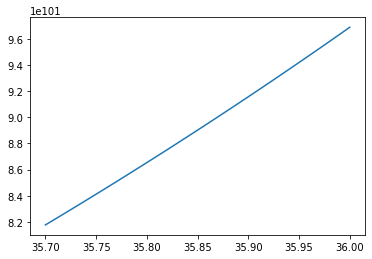

In [59]:
x = []
for i in range(3570,3601):
    x.append(i/100)
y = []
for j in x:
    y.append(samchun_river_calc(j))
print
plt.plot(x,y)
plt.show()